In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
from scipy.special import kn

import pandas as pd
g=20
c2 = 2*(np.pi**2)/45

In [2]:
# Load the data from CSV files
Gstar_df = pd.read_csv("Gstar.csv")
GstarS_df = pd.read_csv("GstarS.csv")

Gstar = dict(zip(Gstar_df.iloc[:, 0], Gstar_df.iloc[:, 1]))
GstarS = dict(zip(GstarS_df.iloc[:, 0], GstarS_df.iloc[:, 1]))

def g_star(Temp):
    # Find closest temperature value in Gstar
    closest_temp = min(Gstar.keys(), key=lambda t: abs(t - Temp))
    return Gstar[closest_temp]

def g_starS(Temp):
    # Find closest temperature value in GstarS
    closest_temp = min(GstarS.keys(), key=lambda t: abs(t - Temp))
    return GstarS[closest_temp]

# Define physical constants
M_Pl = 1.22e19  # Planck mass in GeV

# Particle properties
particle_mass = {
    'Proton': 120,
    'Lambda': 200,
    'Neutron': 100,
    'NeutralPion': 50,
    'ChargedPion': 60,
    'NeutralKaon': 80,
    'ChargedKaon': 90
}

particle_cross_sections = {
    'Proton': 2e-9,
    'Neutron': 1e-9,
    'Lambda': 1e-7,
    'NeutralPion': 4e-9,
    'ChargedPion': 5e-9,
    'NeutralKaon': 5e-9,
    'ChargedKaon': 6e-9,
}

particle_ratios = {
    particle: particle_mass[particle] / particle_mass["Lambda"]
    for particle in particle_mass
}

def n_eq(x, particle):
    mass = particle_mass.get(particle, 1)
    T = mass/x
    return (g/(2*(np.pi**2)))*(mass**2)*(T)*kn(2, x)

# Define s(x, m) function (entropy density)
def s(x, particle):
    mass = particle_mass.get(particle, 1)
    g_starS_vec = np.vectorize(g_starS) 
    return c2 * g_starS_vec(mass / x) * (mass / x)**3

def Y_EQ(x, particle):
    mass = particle_mass.get(particle, 1)
    return n_eq(x, particle) / s(x, particle)

# Function to compute prefactor k
def fk(particle):
    mass = particle_mass.get(particle, 1)
    cross_section = particle_cross_sections.get(particle, 1)
    return np.sqrt(np.pi * M_Pl**2 / 45) * mass * cross_section

# Function to compute variables in the Boltzmann equation
def Variables(x, particle):
    mass = particle_mass.get(particle, 1)
    T = mass / x
    return k * g_star(T) / x**2  # g_star(T) is assumed to be defined elsewhere


# Boltzmann equation in log space
def dYdx_log(x, logY, particle):
    Y = np.exp(logY)
    ratio = particle_ratios.get(particle, 1)
    x_ratio = max(0.01, x * ratio)
    #x_ratio = x * ratio
    return -((Y**2 - Y_EQ(x_ratio, particle)**2) * Variables(x_ratio, particle)) / Y # d(logY)/dx

Frozen-out value of Proton with sigma = 2e-09, and mass = 120 GeV is 2.698943923681799e-13
Frozen-out value of Neutron with sigma = 1e-09, and mass = 100 GeV is 5.846231666886381e-13
Frozen-out value of Lambda with sigma = 1e-07, and mass = 200 GeV is 6.29552789241722e-15
Frozen-out value of NeutralPion with sigma = 4e-09, and mass = 50 GeV is 1.7012827479142898e-13
Frozen-out value of ChargedPion with sigma = 5e-09, and mass = 60 GeV is 1.3181983161518468e-13
Frozen-out value of NeutralKaon with sigma = 5e-09, and mass = 80 GeV is 1.2764517403732023e-13
Frozen-out value of ChargedKaon with sigma = 6e-09, and mass = 90 GeV is 1.0331103883690456e-13
Σm_i*Y_i = 1.2803396038631843e-10 GeV


Text(0.05, 0.001, 'Σm_i*Y_i = 1.28e-10 GeV')

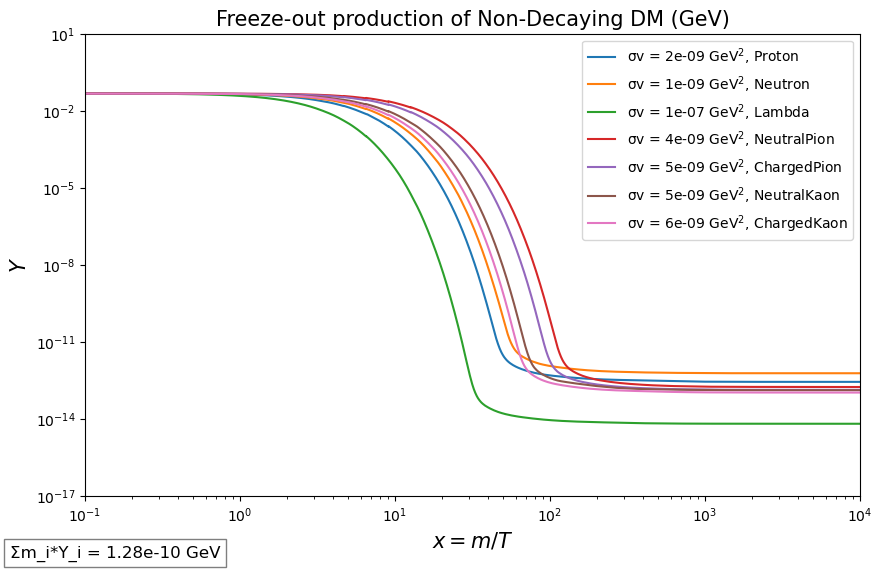

In [11]:
# Integration setup
particles = ["Proton", "Neutron", "Lambda", "NeutralPion", "ChargedPion", "NeutralKaon", "ChargedKaon"]

x_min, x_max = 1e-2, 1E4
x_eval = np.logspace(np.log10(x_min), np.log10(x_max), 10000)

# Plot equilibrium abundance
xx = np.logspace(np.log10(x_min), np.log10(1000), 10000)
#plt.loglog(xx, Y_EQ(xx, 'Proton'), 'c', label=r'$Y_{\rm eq}$, Proton')
plt.figure(figsize=(10, 6))


FreezeOutNumber = np.array([])
masses = np.array([])

for particle in particles:
    cross_section = particle_cross_sections.get(particle, 1)
    mass = particle_mass.get(particle, 1)
    
    k = fk(particle)

    sol = integrate.solve_ivp(
        lambda x, logY: dYdx_log(x, logY, particle),
        (x_min, x_max),
        [np.log(Y_EQ(x_min, particle))],  
        method='BDF',  
        t_eval=x_eval,
        rtol=1e-3,
        atol=1e-3
    )

    # Convert back from log space
    Y_values = np.exp(sol.y[0])

    print(f'Frozen-out value of {particle} with sigma = {cross_section}, and mass = {mass} GeV is {Y_values[-1]}')

    plt.loglog(sol.t, Y_values, label=f'σv = {cross_section} GeV$^{2}$, {particle}')

    FreezeOutNumber = np.append(FreezeOutNumber, Y_values[-1])
    masses = np.append(masses, mass)

print(f'Σm_i*Y_i = {np.sum(np.multiply(masses,FreezeOutNumber))} GeV')


plt.ylim(1E-17,10)
plt.xlim(0.1,x_max)
plt.xlabel('$x = m/T$', size= 15)
plt.ylabel('$Y$', size= 15)
plt.title('Freeze-out production of Non-Decaying DM (GeV)', size= 15)
plt.legend()
plt.gcf().text(0.05, 0.001, f"Σm_i*Y_i = {format(np.sum(np.multiply(masses, FreezeOutNumber)), '.2e')} GeV", fontsize=12, ha='left', va='bottom', bbox=dict(facecolor='white', alpha=0.5))
#plt.show()
#plt.savefig('NonDecayingFreezeOut.png', facecolor = 'w')